We got some insights in the exploration phase, now it is time to see how can we transform the data to prepare them for our models.

In this notebook, we will only focus on the potential transformation, the proper implementation via pipelines will happen in a separate notebook.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
pd.set_option('max_columns', 500)

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
def list_missing(data, verbose=True):
    mis_cols = [col for col in data.columns if data[col].isna().any()]
    if not verbose:
        return mis_cols
    tot_rows = len(data)
    for col in mis_cols:
        print(f'Column {col}: {round(data[col].isna().sum()*100/tot_rows, 2)}% missing')
    return mis_cols


def clean_general(data, train=True):
    df = data.copy()
    if train:
        # remove known outliers from train set
        df = df.loc[df.GrLivArea < 4500].reset_index(drop=True)
    #LotFrontage
    df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = 0
    #Alley
    df.loc[df.Alley.isnull(), 'Alley'] = "NoAlley"
    #MSSubClass
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    #MissingBasement
    fil = ((df.BsmtQual.isnull()) & (df.BsmtCond.isnull()) & (df.BsmtExposure.isnull()) &
          (df.BsmtFinType1.isnull()) & (df.BsmtFinType2.isnull()))
    fil1 = ((df.BsmtQual.notnull()) | (df.BsmtCond.notnull()) | (df.BsmtExposure.notnull()) |
          (df.BsmtFinType1.notnull()) | (df.BsmtFinType2.notnull()))
    df.loc[fil1, 'MisBsm'] = 0
    df.loc[fil, 'MisBsm'] = 1 # made explicit for safety
    #BsmtQual
    df.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
    #BsmtCond
    df.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
    #BsmtExposure
    df.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
    #BsmtFinType1
    df.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
    #BsmtFinType2
    df.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
    #BsmtFinSF1
    df.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
    #BsmtFinSF2
    df.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
    #BsmtUnfSF
    df.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
    #TotalBsmtSF
    df.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
    #BsmtFullBath
    df.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
    #BsmtHalfBath
    df.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
    #FireplaceQu
    df.loc[(df.Fireplaces == 0) & (df.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
    #MisGarage
    fil = ((df.GarageYrBlt.isnull()) & (df.GarageType.isnull()) & (df.GarageFinish.isnull()) &
          (df.GarageQual.isnull()) & (df.GarageCond.isnull()))
    fil1 = ((df.GarageYrBlt.notnull()) | (df.GarageType.notnull()) | (df.GarageFinish.notnull()) |
          (df.GarageQual.notnull()) | (df.GarageCond.notnull()))
    df.loc[fil1, 'MisGarage'] = 0
    df.loc[fil, 'MisGarage'] = 1
    #GarageYrBlt
    df.loc[df.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
    df.loc[fil, 'GarageYrBlt'] = 0
    #GarageType
    df.loc[fil, 'GarageType'] = "NoGrg" #missing garage
    #GarageFinish
    df.loc[fil, 'GarageFinish'] = "NoGrg" #missing
    #GarageQual
    df.loc[fil, 'GarageQual'] = "NoGrg" #missing
    #GarageCond
    df.loc[fil, 'GarageCond'] = "NoGrg" #missing
    #Fence
    df.loc[df.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
    #Pool
    fil = ((df.PoolArea == 0) & (df.PoolQC.isnull()))
    df.loc[fil, 'PoolQC'] = 'NoPool' 
    return df


def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set


def plot_correlations(data, target=None, limit=50, figsize=(12,10), **kwargs):
    corr = data.corr()
    if target:
        cor_target = abs(corr[target]).sort_values(ascending=False)
        cor_target = cor_target[:limit]
        corr = corr.loc[cor_target.index, cor_target.index]
    plt.figure(figsize=figsize)
    ax = sns.heatmap(corr, cmap='RdBu_r', **kwargs)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return cor_target


def plot_distribution(data, column, bins=50, correlation=None):
    plt.figure(figsize=(12,8))
    data[column].hist(bins=bins)
    if not correlation is None:
        value = correlation[column]
        column = column + f' - {round(value,2)}'
    plt.title(f'Distribution of {column}', fontsize=18)
    plt.grid(False)
    
    
def plot_bivariate(data, x, y, hue=None, **kwargs):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, **kwargs)
    if hue:
        plt.title(f'{x} vs {y}, by {hue}', fontsize=18)
    else:
        plt.title(f'{x} vs {y}', fontsize=18)
        
        
def corr_target(data, target, cols, x_estimator=None):
    print(data[cols+[target]].corr())
    num = len(cols)
    rows = int(num/2) + (num % 2 > 0)
    cols = list(cols)
    y = data[target]
    fig, ax = plt.subplots(rows, 2, figsize=(12, 5 * (rows)))
    i = 0
    j = 0
    for feat in cols:
        x = data[feat]
        if (rows > 1):
            sns.regplot(x=x, y=y, ax=ax[i][j], x_estimator=x_estimator)
            j = (j+1)%2
            i = i + 1 - j
        else:
            sns.regplot(x=x, y=y, ax=ax[i], x_estimator=x_estimator)
            i = i+1
            
            
def segm_target(data, cat, target):
    df = data.groupby(cat)[target].agg(['count', 'mean', 'max', 
                                        'min', 'median', 'std'])
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    sns.boxplot(cat, target, data=data, ax=ax[0])
    for val in data[cat].unique():
        tmp = data[data[cat] == val]
        sns.distplot(tmp[target], hist=False, kde=True,
                 kde_kws = {'linewidth': 3, 'alpha': 0.7},
                 label = val, ax=ax[1])  
    return df

In [4]:
df_train = clean_general(df_train)
df_test = clean_general(df_test, train=False)

We are at the same stage as before: we used the documentation to get rid of most of the missing values and errors in the data, now it is time to finish the opera.

# Missing Values

In [5]:
mis_train = list_missing(df_train)
print('_'*40)
print('\n')
mis_test = list_missing(df_test)

Column MasVnrType: 0.55% missing
Column MasVnrArea: 0.55% missing
Column BsmtExposure: 0.07% missing
Column BsmtFinType2: 0.07% missing
Column Electrical: 0.07% missing
Column MiscFeature: 96.3% missing
________________________________________


Column MSZoning: 0.27% missing
Column Utilities: 0.14% missing
Column Exterior1st: 0.07% missing
Column Exterior2nd: 0.07% missing
Column MasVnrType: 1.1% missing
Column MasVnrArea: 1.03% missing
Column BsmtQual: 0.14% missing
Column BsmtCond: 0.21% missing
Column BsmtExposure: 0.14% missing
Column KitchenQual: 0.07% missing
Column Functional: 0.14% missing
Column GarageYrBlt: 0.14% missing
Column GarageFinish: 0.14% missing
Column GarageCars: 0.07% missing
Column GarageArea: 0.07% missing
Column GarageQual: 0.14% missing
Column GarageCond: 0.14% missing
Column PoolQC: 0.21% missing
Column MiscFeature: 96.5% missing
Column SaleType: 0.07% missing


Manual exploration of the test set tells us that some missing values are merely mistakes.

In [6]:
df_test[df_test.BsmtQual.isna()][[col for col in df_test.columns if 'Bsm' in col]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,MisBsm
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0,0.0


In [7]:
df_test[df_test.BsmtCond.isna()][[col for col in df_test.columns if 'Bsm' in col]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,MisBsm
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0,0.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0,0.0


In [8]:
df_test[df_test.GarageQual.isna()][[col for col in df_test.columns if 'Garage' in col]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,MisGarage
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,0.0
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [9]:
def clean_test(data):
    fil = data.GarageYrBlt.isna()
    df = data.copy()
    df.loc[fil, 'GarageType'] = 'NoGrg'
    df.loc[fil, 'GarageYrBlt'] = 0
    df.loc[fil, 'GarageFinish'] = 'NoGrg'
    df.loc[fil, 'GarageCars'] = 0
    df.loc[fil, 'GarageArea'] = 0
    df.loc[fil, 'GarageQual'] = 'NoGrg'
    df.loc[fil, 'GarageCond'] = 'NoGrg'
    df.loc[fil, 'MisGarage'] = 1
    return df

In [10]:
df_test = clean_test(df_test)
mis_test = list_missing(df_test)

Column MSZoning: 0.27% missing
Column Utilities: 0.14% missing
Column Exterior1st: 0.07% missing
Column Exterior2nd: 0.07% missing
Column MasVnrType: 1.1% missing
Column MasVnrArea: 1.03% missing
Column BsmtQual: 0.14% missing
Column BsmtCond: 0.21% missing
Column BsmtExposure: 0.14% missing
Column KitchenQual: 0.07% missing
Column Functional: 0.14% missing
Column PoolQC: 0.21% missing
Column MiscFeature: 96.5% missing
Column SaleType: 0.07% missing


# Transforming interesting columns

We have seen before that the target has a better distribution if we take the log of it. Let's do it again and split the data in the usual training and test set.

In [11]:
df_train['Target'] = np.log1p(df_train.SalePrice)

del df_train['SalePrice']

In [12]:
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

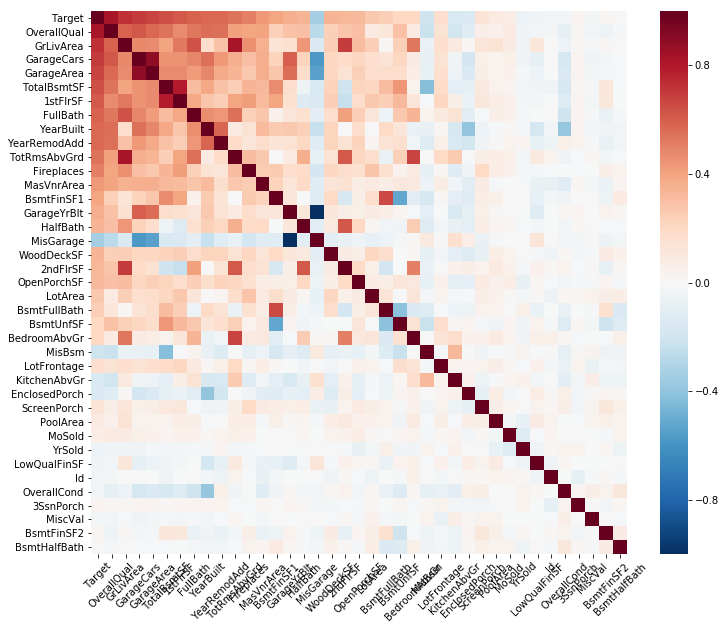

In [13]:
high_corr = plot_correlations(train_set, 'Target')

We can remove the skewness of some columns.

In [14]:
def remove_skew(data, column):
    df = data.copy()
    df[column] = np.log1p(df[column])
    return df

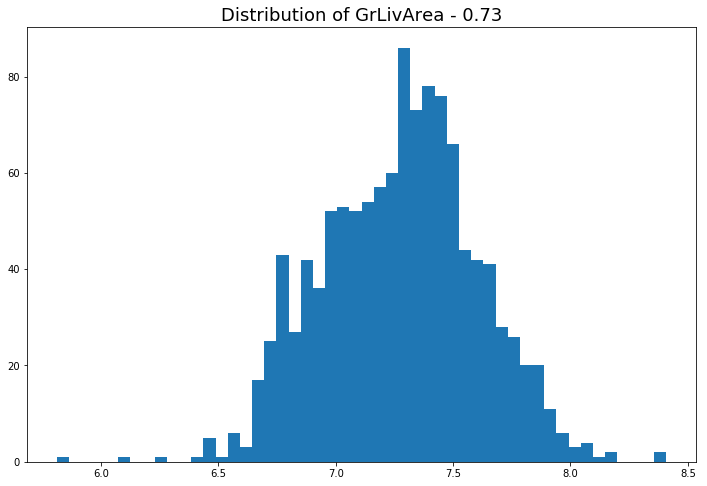

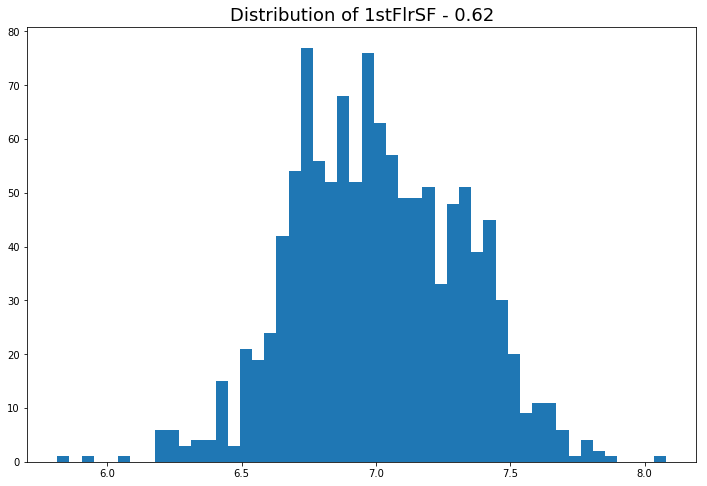

In [15]:
for col in ['GrLivArea', '1stFlrSF']:
    train_set = remove_skew(train_set, col)
    test_set = remove_skew(test_set, col)
    plot_distribution(train_set, col, correlation=high_corr)

             OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
OverallQual     1.000000   0.606274    0.618582    0.577956     0.541684   
GrLivArea       0.606274   1.000000    0.501244    0.479462     0.407895   
GarageCars      0.618582   0.501244    1.000000    0.889179     0.449308   
GarageArea      0.577956   0.479462    0.889179    1.000000     0.474743   
TotalBsmtSF     0.541684   0.407895    0.449308    0.474743     1.000000   
1stFlrSF        0.452048   0.532700    0.450342    0.476024     0.774240   
Target          0.826131   0.741597    0.696102    0.673793     0.641253   

             1stFlrSF    Target  
OverallQual  0.452048  0.826131  
GrLivArea    0.532700  0.741597  
GarageCars   0.450342  0.696102  
GarageArea   0.476024  0.673793  
TotalBsmtSF  0.774240  0.641253  
1stFlrSF     1.000000  0.611572  
Target       0.611572  1.000000  


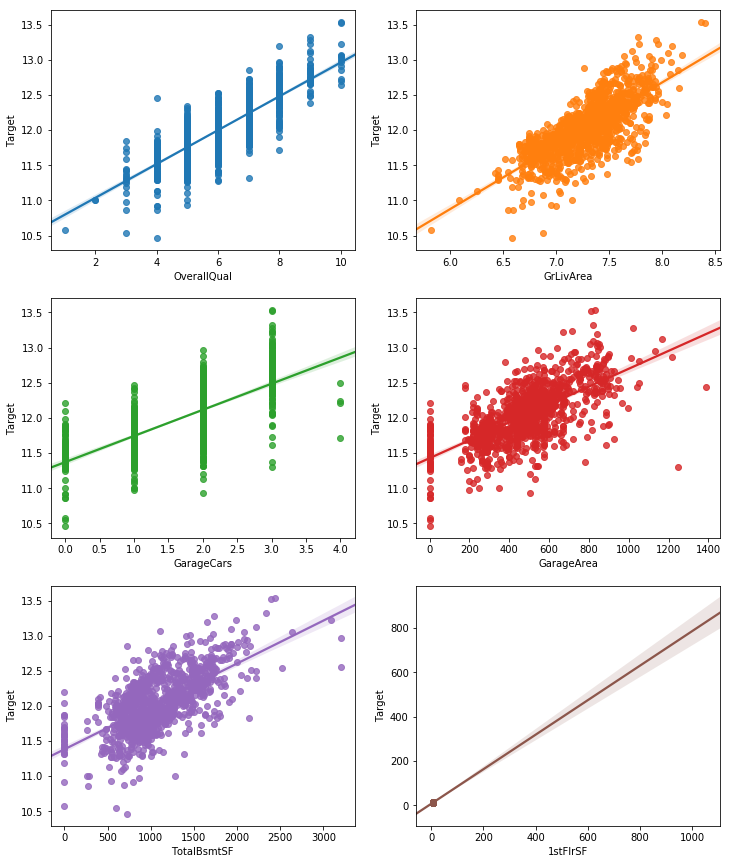

In [16]:
corr_target(train_set, 'Target', list(high_corr[1:7].index))

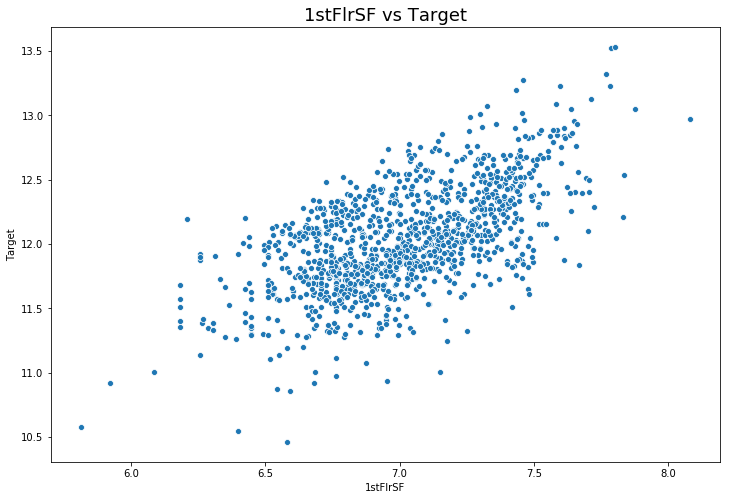

In [17]:
plot_bivariate(train_set, x='1stFlrSF', y='Target')

Much better looking indeed.

## Categorical features

We have seen before that some of these are actually ordinal features, let's take care of that.

In [18]:
def make_ordinal(data, column, mapping, new_name):
    data[new_name] = data[column].map(mapping).fillna(0)
    return data

In [19]:
for col in ['BsmtQual', 'KitchenQual','GarageQual', 'GarageCond', 
            'ExterQual', 'HeatingQC']:
    train_set = make_ordinal(train_set, col, 
                         {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                         col+'_ord')

                 BsmtQual_ord  KitchenQual_ord  GarageQual_ord  \
BsmtQual_ord         1.000000         0.511100        0.171536   
KitchenQual_ord      0.511100         1.000000        0.232329   
GarageQual_ord       0.171536         0.232329        1.000000   
GarageCond_ord       0.188111         0.224139        0.955815   
ExterQual_ord        0.554887         0.714989        0.214681   
HeatingQC_ord        0.403084         0.499017        0.176256   
Target               0.607152         0.690173        0.372389   

                 GarageCond_ord  ExterQual_ord  HeatingQC_ord    Target  
BsmtQual_ord           0.188111       0.554887       0.403084  0.607152  
KitchenQual_ord        0.224139       0.714989       0.499017  0.690173  
GarageQual_ord         0.955815       0.214681       0.176256  0.372389  
GarageCond_ord         1.000000       0.210297       0.181200  0.365264  
ExterQual_ord          0.210297       1.000000       0.520420  0.688002  
HeatingQC_ord          0.18

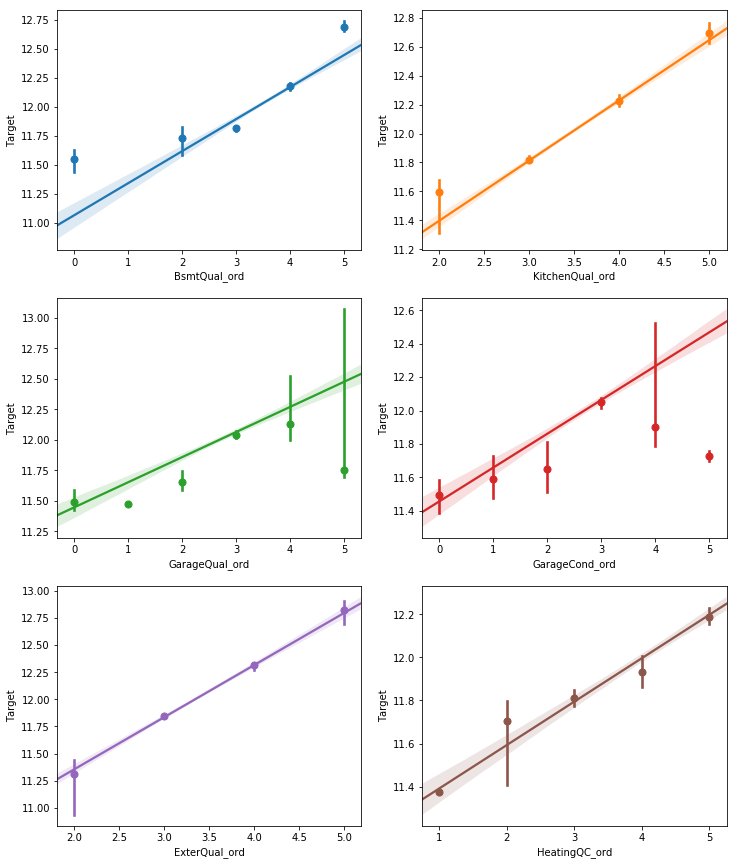

In [20]:
corr_target(train_set, 'Target', ['BsmtQual_ord', 'KitchenQual_ord', 
                                  'GarageQual_ord', 'GarageCond_ord',
                                 'ExterQual_ord', 'HeatingQC_ord'], x_estimator=np.median)

We indeed observe a linear relation between the target and some of these features. For others it will be probably be better to use a different encoding.

Using the previously obtained insights, we can recode some of the remaining categorical features

In [21]:
def tr_GrgType(data):
    data['GrgType_recoded'] = data['GarageType'].map({'Basment': 'Attchd', 
                                                      'CarPort': 'Detchd', 
                                                      '2Types': 'Attchd' }).fillna(data['GarageType'])
    return data

,count,mean,max,min,median,std
GrgType_recoded,,,,,,
Attchd,705,12.154445,13.534474,10.933000,12.119975,0.340577
BuiltIn,76,12.381833,13.275829,11.418626,12.334850,0.393289
Detchd,320,11.771839,13.071072,10.976799,11.763692,0.272710
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975


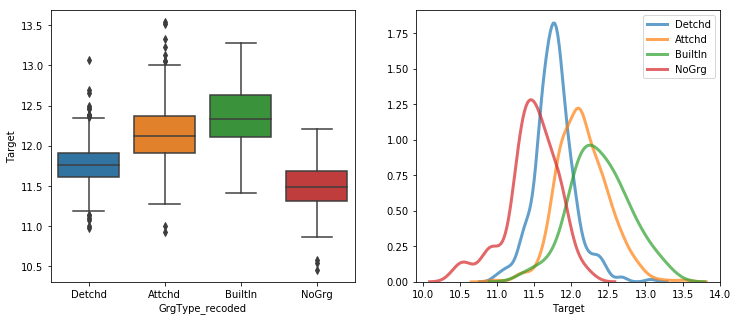

In [22]:
train_set = tr_GrgType(train_set)
segm_target(train_set, 'GrgType_recoded', 'Target')

This created a feature with categories with enough observations and a more clear signal.

In [23]:
def tr_LotShape(data):
    data['LotShape_recoded'] = 1
    data.loc[data.LotShape != 'Reg', 'LotShape_recoded'] = 0
    return data

,count,mean,max,min,median,std
LotShape_recoded,,,,,,
0,412,12.197584,13.534474,10.859018,12.173035,0.373691
1,754,11.932324,13.275829,10.460271,11.884496,0.383705


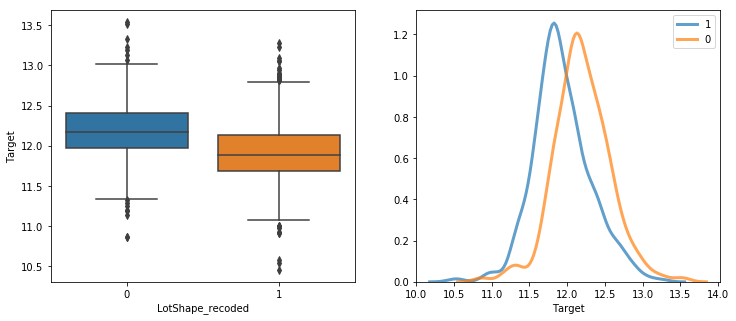

In [24]:
train_set = tr_LotShape(train_set)
segm_target(train_set, 'LotShape_recoded', 'Target')

In [25]:
def tr_LandCont(data):
    data['LandContour_recoded'] = 0
    data.loc[(data.LandContour == 'HLS') | (data.LandContour == 'Low'), 'LandContour_recoded'] = 1
    return data

,count,mean,max,min,median,std
LandContour_recoded,,,,,,
0,1099,12.013314,13.534474,10.460271,11.984185,0.392571
1,67,12.234984,13.195616,10.579005,12.341263,0.471720


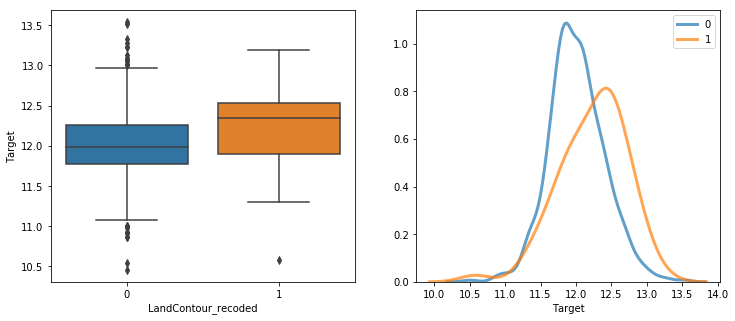

In [26]:
train_set = tr_LandCont(train_set)
segm_target(train_set, 'LandContour_recoded', 'Target')

In [27]:
def tr_LandSlope(data):
    data['LandSlope_recoded'] = 0
    data.loc[data.LandSlope != 'Gtl', 'LandSlope_recoded'] = 1
    return data

,count,mean,max,min,median,std
LandSlope_recoded,,,,,,
0,1105,12.021629,13.534474,10.460271,11.995358,0.393935
1,61,12.106164,13.195616,10.579005,12.154785,0.504430


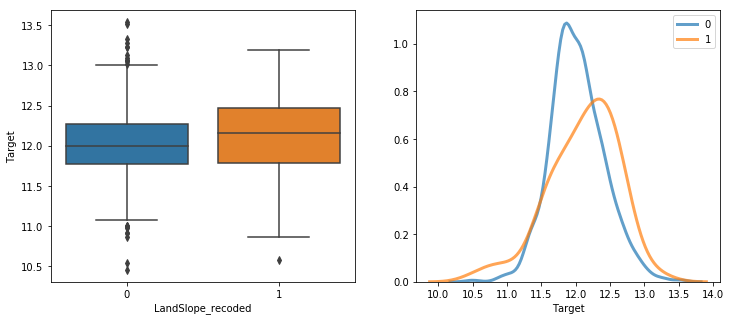

In [28]:
train_set = tr_LandSlope(train_set)
segm_target(train_set, 'LandSlope_recoded', 'Target')

In [29]:
def tr_MSZoning(data):
    data['MSZoning_recoded'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                      'C (all)': 'RM', # commercial and medium density
                                                    'FV': 'RM'}).fillna(data['MSZoning'])
    return data

,count,mean,max,min,median,std
MSZoning_recoded,,,,,,
RL,915,12.089927,13.534474,10.579005,12.072547,0.382054
RM,251,11.793201,13.071072,10.460271,11.774528,0.380788


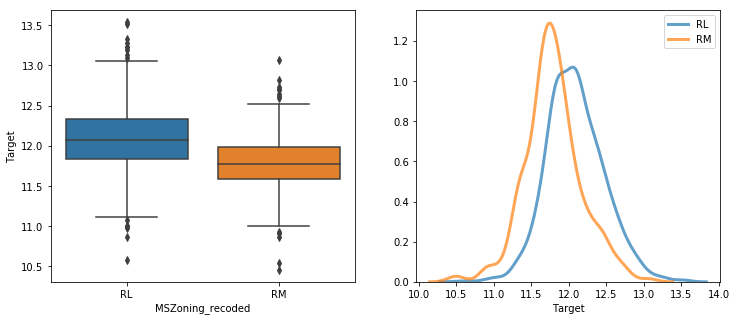

In [30]:
train_set = tr_MSZoning(train_set)
segm_target(train_set, 'MSZoning_recoded', 'Target')

In [31]:
def tr_Alley(data):
    data['Alley_recoded'] = 0
    data.loc[data.Alley != 'NoAlley', 'Alley_recoded'] = 1
    return data

,count,mean,max,min,median,std
Alley_recoded,,,,,,
0,1092,12.038498,13.534474,10.460271,12.014161,0.402332
1,74,11.842391,12.491176,10.868587,11.896140,0.325570


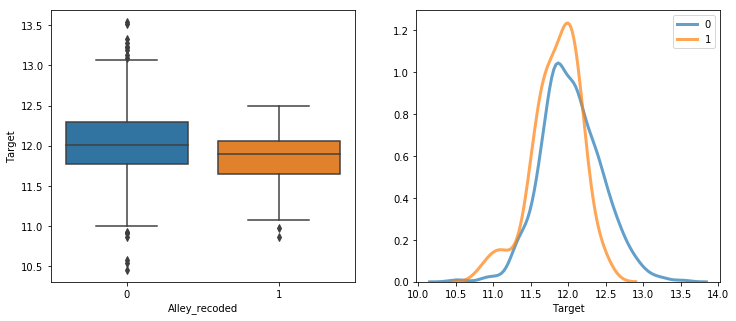

In [32]:
train_set = tr_Alley(train_set)
segm_target(train_set, 'Alley_recoded', 'Target') #nothing useful here

In [33]:
def tr_LotConfig(data):
    data['LotConfig_recoded'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                      'FR2': 'Corner'}).fillna(data['LotConfig'])
    return data

,count,mean,max,min,median,std
LotConfig_recoded,,,,,,
Corner,242,12.028607,13.534474,10.868587,12.013707,0.387860
CulDSac,77,12.260282,13.195616,11.338584,12.259618,0.350309
Inside,847,12.004028,13.323929,10.460271,11.976666,0.402102


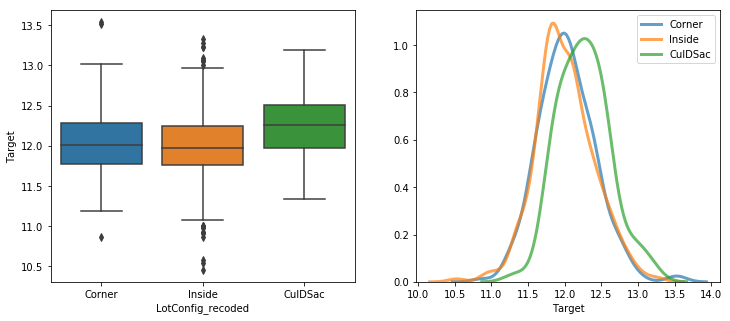

In [34]:
train_set = tr_LotConfig(train_set)
segm_target(train_set, 'LotConfig_recoded', 'Target')  # weak but visible pattern

In [36]:
def tr_BldgType(data):
    data['BldgType_recoded'] = data['BldgType'].map({'Twnhs' : 'TwnhsE', 
                                                     '2fmCon': 'Duplex'}).fillna(data['BldgType'])
    return data

,count,mean,max,min,median,std
BldgType_recoded,,,,,,
1Fam,973,12.051200,13.534474,10.460271,12.040614,0.409581
Duplex,68,11.759224,12.341263,10.915107,11.808947,0.238438
TwnhsE,125,11.975450,12.813921,11.289794,11.956976,0.340291


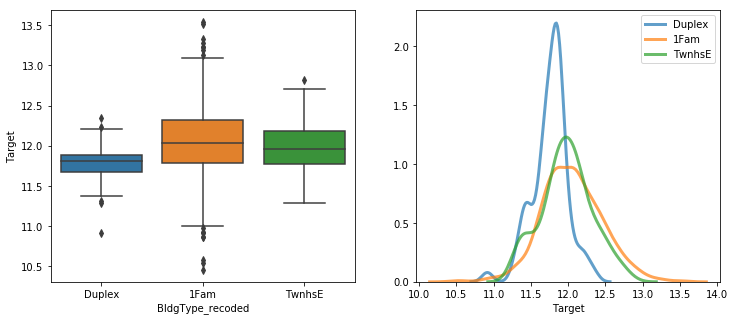

In [38]:
train_set = tr_BldgType(train_set)
segm_target(train_set, 'BldgType_recoded', 'Target')

In [41]:
def tr_MasVnrType(data):
    data['MasVnrType_recoded'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
    return data

/home/lucabasa/.local/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/lucabasa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,count,mean,max,min,median,std
MasVnrType_recoded,,,,,,
BrkFace,363,12.164631,13.534474,11.320566,12.106258,0.348455
None,697,11.893713,13.521141,10.460271,11.867104,0.364996
Stone,98,12.429558,13.323929,11.686887,12.425865,0.377575


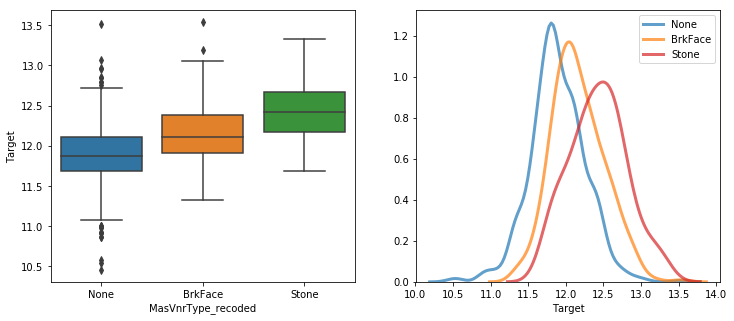

In [42]:
train_set = tr_MasVnrType(train_set)
segm_target(train_set, 'MasVnrType_recoded', 'Target')